# Preprocessing

## Load Data

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load the dataset
df = pd.read_csv('processed_data.csv')

cpu


## Feature Selection

In [162]:
features = [
    'GENDER', 'AGE RANGE OF ENROLLED STUDENT', 'BENEFIT DISCOUNTS', 'STUDY MODE',
    'SHIFT/SCHEDULE', 'ENROLLMENT',
    'PROGRAM/MAJOR', 'DEPARTMENT', 'NUMBER OF ENROLLED COURSES', 'TUITION PAYMENT MARCH 2022'
]

target = 'TUITION PAYMENT MARCH 2023'

corr_df = df[features + [target]].copy()
# Compute correlations with the target
correlations = corr_df.corr(numeric_only=True)[target].abs().sort_values(ascending=False)

print("Correlation of Features with Target (COURSE_CLASS):")
print(correlations)


Correlation of Features with Target (COURSE_CLASS):
TUITION PAYMENT MARCH 2023       1.000000
TUITION PAYMENT MARCH 2022       0.922731
ENROLLMENT                       0.327749
AGE RANGE OF ENROLLED STUDENT    0.061663
GENDER                           0.043202
NUMBER OF ENROLLED COURSES       0.033821
SHIFT/SCHEDULE                   0.030778
STUDY MODE                       0.014902
BENEFIT DISCOUNTS                0.014032
DEPARTMENT                       0.012320
PROGRAM/MAJOR                    0.001469
Name: TUITION PAYMENT MARCH 2023, dtype: float64


# Tuition Payment

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 1. Select features and target
features = ['ENROLLMENT', 'TUITION PAYMENT MARCH 2022']
target = 'TUITION PAYMENT MARCH 2023'

X = df[features]
y = df[target]

# 2. Split into train (80%), temp (20%) first
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# 3. Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=42
)

# Print shapes
print("Total samples:", len(X))
print("X_train shape:", X_train.shape)  # ~80%
print("X_val shape:", X_val.shape)      # ~10%
print("X_test shape:", X_test.shape)    # ~10%
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

# Initialize Scores dictionary
Scores = {}

Total samples: 36584
X_train shape: (21950, 2)
X_val shape: (7317, 2)
X_test shape: (7317, 2)
y_train shape: (21950,)
y_val shape: (7317,)
y_test shape: (7317,)


## Define Classifier Head

In [164]:
from sklearn.base import BaseEstimator, ClassifierMixin

class RoundOffRegressorClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_regressor):
        self.base_regressor = base_regressor

    def fit(self, X, y):
        self.base_regressor.fit(X, y)
        return self

    def predict(self, X):
        preds = self.base_regressor.predict(X)
        return np.round(preds).astype(int)

# Models

## Regressor

### Linear

In [165]:
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
# 5. Train model
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.019981679697596098
R² Score: 0.845071559389955


### Ridge

In [196]:
from sklearn.linear_model import Ridge

# Ridge regression pipeline
ridge_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0))  # You can tune alpha
])

# Train Ridge model
ridge_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_test)

print("Ridge Regression")
print("MSE:", mean_squared_error(y_test, y_pred_ridge))
print("R² Score:", r2_score(y_test, y_pred_ridge))


Ridge Regression
MSE: 0.019981701707199345
R² Score: 0.8450713887379597


### Lasso

In [167]:
from sklearn.linear_model import Lasso

# Lasso regression pipeline
lasso_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=0.1, max_iter=10000))  # You can tune alpha
])

# Train Lasso model
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test)
print("Lasso Regression")
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("R² Score:", r2_score(y_test, y_pred_lasso))


Lasso Regression
MSE: 0.0296619532582787
R² Score: 0.77001532237022


## Classification

In [168]:
from sklearn.metrics import classification_report, accuracy_score

### Linear + Classifier

In [169]:
model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RoundOffRegressorClassifier(LinearRegression()))
])
# 5. Train model
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)
linear_score = accuracy_score(y_test, y_pred)
Scores['Linear Regression'] = linear_score

print("Linear Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Linear Regression
Accuracy: 0.9794997949979499
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1113
           1       0.98      1.00      0.99      6204

    accuracy                           0.98      7317
   macro avg       0.99      0.93      0.96      7317
weighted avg       0.98      0.98      0.98      7317



d:\Dev\python\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


### Ridge + Classifier

In [187]:
from sklearn.linear_model import Ridge

# Ridge regression pipeline
ridge_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RoundOffRegressorClassifier(Ridge(alpha=1.0)))
])

# Train Ridge model
ridge_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_test)
ri_score = accuracy_score(y_test, y_pred_ridge)
Scores['Ridge Regression'] = ri_score

# Evaluate
print("Ridge Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_ridge))
print(classification_report(y_test, y_pred_ridge))


Ridge Regression
Accuracy: 0.9794997949979499
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1113
           1       0.98      1.00      0.99      6204

    accuracy                           0.98      7317
   macro avg       0.99      0.93      0.96      7317
weighted avg       0.98      0.98      0.98      7317



d:\Dev\python\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


### Lasso + Classfier

In [171]:
from sklearn.linear_model import Lasso

# Lasso regression pipeline
lasso_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RoundOffRegressorClassifier(Lasso(alpha=0.1, max_iter=10000)))
])

# Train Lasso model
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test)
la_score = accuracy_score(y_test, y_pred_lasso)
Scores['Lasso Regression'] = la_score
# Evaluate
print("Lasso Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lasso))
print(classification_report(y_test, y_pred_lasso))


Lasso Regression
Accuracy: 0.9794997949979499
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1113
           1       0.98      1.00      0.99      6204

    accuracy                           0.98      7317
   macro avg       0.99      0.93      0.96      7317
weighted avg       0.98      0.98      0.98      7317



d:\Dev\python\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## Logistic Regression

In [172]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression pipeline
log_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Required for logistic regression
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000))
])

# Train Logistic Regression model
log_pipeline.fit(X_train, y_train)
# Predict and evaluate
y_pred_log = log_pipeline.predict(X_test)
lg_score = accuracy_score(y_test, y_pred_log)
Scores['Logistic Regression'] = lg_score
# Evaluate
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression
Accuracy: 0.9794997949979499
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1113
           1       0.98      1.00      0.99      6204

    accuracy                           0.98      7317
   macro avg       0.99      0.93      0.96      7317
weighted avg       0.98      0.98      0.98      7317



d:\Dev\python\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


## Random Forest Classifier

In [173]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Required for Random Forest
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train Random Forest model
rf_pipeline.fit(X_train, y_train)
# Predict and evaluate
y_pred_rf = rf_pipeline.predict(X_test)
rf_score = accuracy_score(y_test, y_pred_rf)
Scores['Random Forest'] = rf_score
# Evaluate
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest
Accuracy: 0.9794997949979499
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1113
           1       0.98      1.00      0.99      6204

    accuracy                           0.98      7317
   macro avg       0.99      0.93      0.96      7317
weighted avg       0.98      0.98      0.98      7317



## XGBoost

In [174]:
from xgboost import XGBClassifier

# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Required for XGBoost
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Train XGBoost model
xgb_pipeline.fit(X_train, y_train)
# Predict and evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)
xg_score = accuracy_score(y_test, y_pred_xgb)
Scores['XGBoost'] = xg_score
# Evaluate
print("XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))



XGBoost
Accuracy: 0.9794997949979499
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1113
           1       0.98      1.00      0.99      6204

    accuracy                           0.98      7317
   macro avg       0.99      0.93      0.96      7317
weighted avg       0.98      0.98      0.98      7317



d:\Dev\python\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## ANN

In [175]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR



# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [176]:
class DeepNN(nn.Module):
    def __init__(self, input_dim, num_classes, apply_softmax=False):
        super(DeepNN, self).__init__()
        self.apply_softmax = apply_softmax
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        if self.apply_softmax:
            return F.softmax(x, dim=1)
        return x


In [184]:
input_dim = X_train.shape[1]
num_classes = len(y.unique())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Initialize model, loss function, and optimizer
model = DeepNN(input_dim=input_dim, num_classes=num_classes, apply_softmax=False).to(device)
criterion = nn.CrossEntropyLoss()  # This expects raw logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)  # Cosine Annealing scheduler

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()  # Step the scheduler after each epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
# Evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        _, predicted = torch.max(out, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
accuracy = correct / total
Scores['DeepNN'] = accuracy
print("Deep Neural Network")
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))


cpu
Epoch 1/50, Loss: 40.3722
Epoch 2/50, Loss: 34.6052
Epoch 3/50, Loss: 34.4424
Epoch 4/50, Loss: 34.0734
Epoch 5/50, Loss: 33.5455
Epoch 6/50, Loss: 33.4075
Epoch 7/50, Loss: 33.3482
Epoch 8/50, Loss: 33.2650
Epoch 9/50, Loss: 33.3144
Epoch 10/50, Loss: 33.1980
Epoch 11/50, Loss: 33.1598
Epoch 12/50, Loss: 33.1025
Epoch 13/50, Loss: 33.2591
Epoch 14/50, Loss: 33.0841
Epoch 15/50, Loss: 33.1806
Epoch 16/50, Loss: 33.1368
Epoch 17/50, Loss: 33.2915
Epoch 18/50, Loss: 33.5929
Epoch 19/50, Loss: 33.2677
Epoch 20/50, Loss: 33.1271
Epoch 21/50, Loss: 33.3048
Epoch 22/50, Loss: 33.0668
Epoch 23/50, Loss: 33.2040
Epoch 24/50, Loss: 32.8734
Epoch 25/50, Loss: 33.0545
Epoch 26/50, Loss: 32.8123
Epoch 27/50, Loss: 32.8292
Epoch 28/50, Loss: 32.9465
Epoch 29/50, Loss: 32.7658
Epoch 30/50, Loss: 32.7142
Epoch 31/50, Loss: 32.8436
Epoch 32/50, Loss: 32.7456
Epoch 33/50, Loss: 32.6423
Epoch 34/50, Loss: 32.7400
Epoch 35/50, Loss: 32.7732
Epoch 36/50, Loss: 32.9315
Epoch 37/50, Loss: 32.6905
Epoch 

## Model Comparison

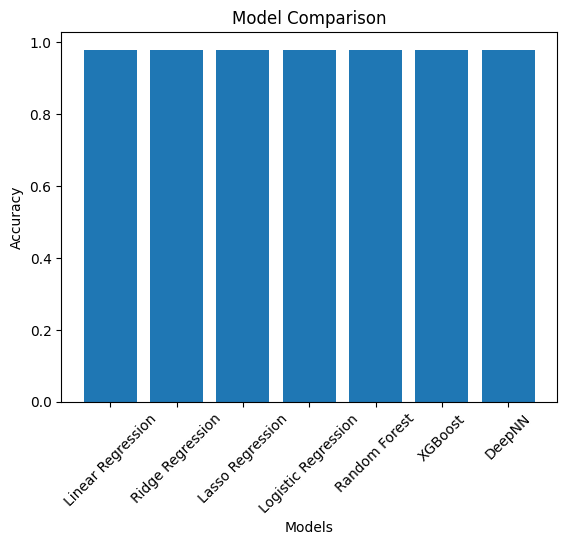

In [178]:
plt.Figure(figsize=(12, 5))
plt.bar(Scores.keys(), Scores.values())
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.savefig('Model_Comparison.png', bbox_inches='tight')
plt.show()

## Ensemble

In [179]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Define individual model pipelines (with same preprocessing)
log_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

rf_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

xgb_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        objective='multi:softmax',
        num_class=len(y.unique()),
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ))
])

# Ensemble Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', log_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='hard'  # use 'soft' for probabilities if supported
)

# Train and evaluate
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


d:\Dev\python\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Dev\python\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Accuracy: 0.9794997949979499
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1113
           1       0.98      1.00      0.99      6204

    accuracy                           0.98      7317
   macro avg       0.99      0.93      0.96      7317
weighted avg       0.98      0.98      0.98      7317



# Finding Correlation

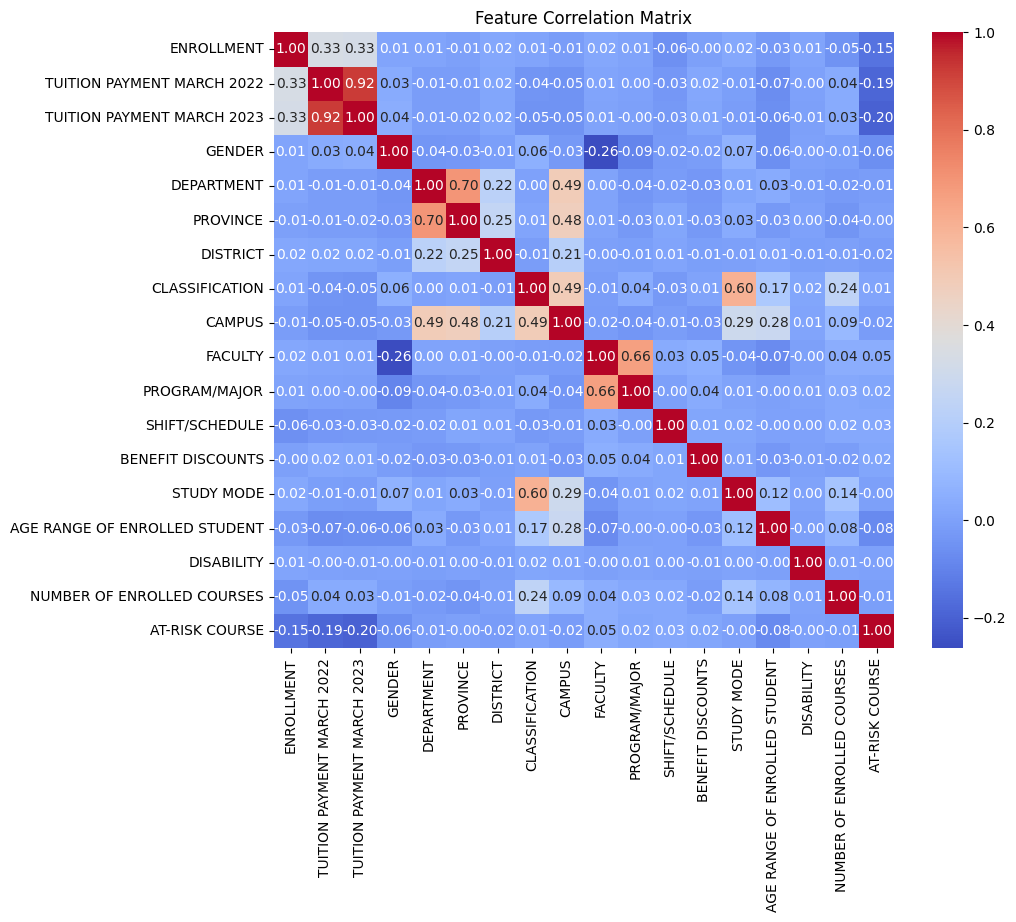

In [180]:
# Ensure only numeric features are used
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot it for reference
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [181]:
# Sum absolute correlations for each feature (excluding self-correlation)
corr_sums = corr_matrix.abs().sum(axis=1) - 1  # subtract 1 for self-correlation

# Sort to find most 'connected' features
sorted_corr = corr_sums.sort_values(ascending=False)
print("Features most correlated with other numeric features:")
print(sorted_corr)


Features most correlated with other numeric features:
CAMPUS                           2.591641
TUITION PAYMENT MARCH 2023       1.804974
CLASSIFICATION                   1.803353
TUITION PAYMENT MARCH 2022       1.793102
PROVINCE                         1.692367
DEPARTMENT                       1.675508
STUDY MODE                       1.404580
FACULTY                          1.300251
AGE RANGE OF ENROLLED STUDENT    1.127483
ENROLLMENT                       1.074932
PROGRAM/MAJOR                    1.008336
NUMBER OF ENROLLED COURSES       0.870695
AT-RISK COURSE                   0.866011
GENDER                           0.847174
DISTRICT                         0.838061
SHIFT/SCHEDULE                   0.348346
BENEFIT DISCOUNTS                0.336492
DISABILITY                       0.083986
dtype: float64


# Clustering

## KMeans

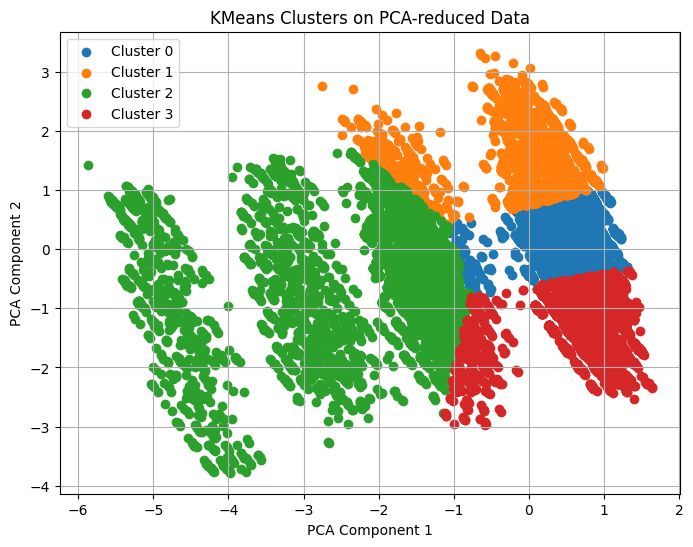

Purity Score: 0.9360


In [182]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# 1. Select features and target
features = [
    'GENDER', 'AGE RANGE OF ENROLLED STUDENT', 'BENEFIT DISCOUNTS', 'STUDY MODE',
    'SHIFT/SCHEDULE', 'ENROLLMENT',
    'PROGRAM/MAJOR', 'DEPARTMENT', 'NUMBER OF ENROLLED COURSES', 'TUITION PAYMENT MARCH 2022'
]
target = 'TUITION PAYMENT MARCH 2023'

X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- Step 2: Clustering (KMeans) ---
n_clusters = 4  # assume number of clusters = number of true classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(X_pca)

# --- Step 3: Plot the clusters ---
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    plt.scatter(
        X_pca[y_pred == cluster, 0],
        X_pca[y_pred == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.title("KMeans Clusters on PCA-reduced Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.savefig('KMeans_clustering_4.png', bbox_inches='tight')
plt.show()
# --- Step 4: Calculate Purity ---
def purity_score(y_true, y_pred):
    # compute contingency matrix (confusion matrix)
    contingency_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

purity = purity_score(y, y_pred)
print(f"Purity Score: {purity:.4f}")


## DBScan

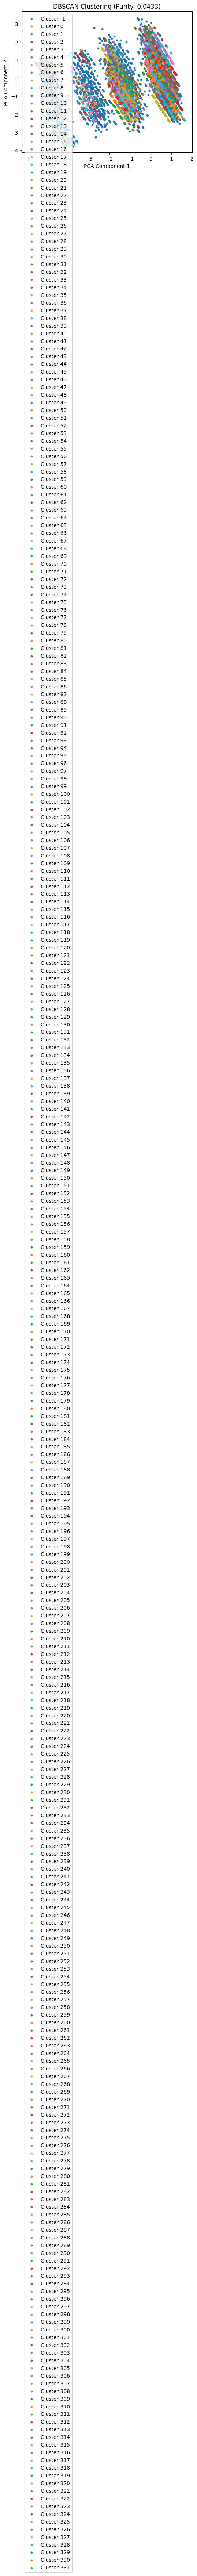

'\n1,5: 338 clusters, 0.0433 purity\n1,10: 331 clusters 0.04333 purity\n2,5: 23 clusters 0.4970 purity\n2,10: 18 clusters  0.4981 purity\n3,5: 5 clusters 0.8275 purity\n3,10: 4 clusters 0.8278 purity\n4,5: 3 clusters 0.8437 purity\n4,10: 3 clusters 0.8437 purity\n5,5: 1 clusters 0.8429 purity\n5,10: 1 clusters 0.8429 purity\n'

In [183]:
# Purity function
def purity_score(y_true, y_pred):
    contingency = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-contingency)
    return contingency[row_ind, col_ind].sum() / np.sum(contingency)

# Plotting function
def plot_clusters(X, labels, title):
    plt.figure(figsize=(6, 5))
    for label in np.unique(labels):
        plt.scatter(X[labels == label, 0], X[labels == label, 1], label=f'Cluster {label}', s=10)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.savefig("DBScan.png", bbox_inches='tight')
    plt.show()
# DBSCAN
dbscan = DBSCAN(eps=1, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
# Remove noise (-1) for purity calculation if needed
dbscan_valid = dbscan_labels != -1
if len(np.unique(dbscan_labels[dbscan_valid])) > 0:
    dbscan_purity = purity_score(y[dbscan_valid], dbscan_labels[dbscan_valid])
else:
    dbscan_purity = 0
plot_clusters(X_pca, dbscan_labels, f'DBSCAN Clustering (Purity: {dbscan_purity:.4f})')

'''
1,5: 338 clusters, 0.0433 purity
1,10: 331 clusters 0.04333 purity
2,5: 23 clusters 0.4970 purity
2,10: 18 clusters  0.4981 purity
3,5: 5 clusters 0.8275 purity
3,10: 4 clusters 0.8278 purity
4,5: 3 clusters 0.8437 purity
4,10: 3 clusters 0.8437 purity
5,5: 1 clusters 0.8429 purity
5,10: 1 clusters 0.8429 purity
'''